## Importing Libraries

In [8]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jenishkothari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jenishkothari/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Loading glove embeddings

Example : 
 "the" : ["3.2",.... 100]

In [10]:
def load_glove_embeddings(file_path, embedding_dim=100):
    word2idx = {"<PAD>": 0}
    idx2word = {0: "<PAD>"}
    embeddings = [np.zeros(embedding_dim)]

    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word2idx[word] = i + 1
            idx2word[i + 1] = word
            embeddings.append(vector)

    return word2idx, idx2word, torch.tensor(embeddings, dtype=torch.float32)
    
glove_path = "glove.6B.100d.txt"
word2idx, idx2word, glove_embeddings = load_glove_embeddings(glove_path)
print("Embeddings shape:", glove_embeddings.shape)
print("Embeddings example:", glove_embeddings[word2idx["the"]])
print("Embeddings example:", glove_embeddings[word2idx["hello"]])
print("Index of 'the':", word2idx["the"])
print("Index of 'hello':", word2idx["hello"])


Embeddings shape: torch.Size([400001, 100])
Embeddings example: tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
        -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
         0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
         0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
         0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
        -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
        -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
         0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
         1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
        -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
         0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
         0.3710, -0.2522,  0.0162, -0.0171, -0.3898,  0.

## Loading 20NG dataset and preprocessing

In [11]:
categories = ['comp.graphics', 'rec.sport.baseball', 'sci.space', 'talk.politics.mideast', 'alt.atheism']
ng_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
ng_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))


def doc2ind(doc, word2idx, max_length=100):
    tokens = word_tokenize(doc.lower())
    indices = [word2idx.get(word, 0) for word in tokens]
    return indices[:max_length] + [0] * (max_length - len(indices))

train_indices = [doc2ind(text, word2idx) for text in ng_train.data]
test_indices = [doc2ind(text, word2idx) for text in ng_test.data]

train_labels = torch.tensor(ng_train.target, dtype=torch.long)
test_labels = torch.tensor(ng_test.target, dtype=torch.long)
train_data = torch.tensor(train_indices, dtype=torch.long)
test_data = torch.tensor(test_indices, dtype=torch.long)

print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: torch.Size([2818, 100])
Train labels shape: torch.Size([2818])
Test data shape: torch.Size([1875, 100])
Test labels shape: torch.Size([1875])


## Custom Implementation of NGDataset

In [12]:
class NGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

batch_size = 32
train_loader = DataLoader(NGDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(NGDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)

## Defining Neural Network Architecture

In [6]:
class SimpleTextClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes):
        super(SimpleTextClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.pool = nn.AdaptiveAvgPool1d(1)  
        self.fc = nn.Linear(embedding_dim, num_classes) 
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x) 
        x = x.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return self.softmax(x)

## Training the model with Freezed Embeddings

In [13]:
num_classes = len(categories)
model = SimpleTextClassifier(glove_embeddings, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

train_model(model, train_loader, epochs=20)

Epoch 1, Loss: 142.6531
Epoch 2, Loss: 141.1873
Epoch 3, Loss: 139.6113
Epoch 4, Loss: 137.9036
Epoch 5, Loss: 136.6443
Epoch 6, Loss: 135.2578
Epoch 7, Loss: 133.8267
Epoch 8, Loss: 132.3791
Epoch 9, Loss: 131.2702
Epoch 10, Loss: 130.0353
Epoch 11, Loss: 129.0109
Epoch 12, Loss: 127.8785
Epoch 13, Loss: 126.6493
Epoch 14, Loss: 125.9783
Epoch 15, Loss: 125.1120
Epoch 16, Loss: 124.0730
Epoch 17, Loss: 123.2346
Epoch 18, Loss: 122.7357
Epoch 19, Loss: 122.3926
Epoch 20, Loss: 121.5093


In [14]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

accuracy = evaluate(model, test_loader)
print(f"Test Accuracy (Frozen Embeddings): {accuracy:.2%}")

Test Accuracy (Frozen Embeddings): 69.17%


## Training the model with unfreezed embeddings

In [15]:
model.embedding.weight.requires_grad = True
train_model(model, train_loader, epochs=10)

accuracy = evaluate(model, test_loader)
print(f"Test Accuracy (Fine-Tuned Embeddings): {accuracy:.2%}")

Epoch 1, Loss: 119.7985
Epoch 2, Loss: 116.5514
Epoch 3, Loss: 113.6154
Epoch 4, Loss: 111.0586
Epoch 5, Loss: 108.4989
Epoch 6, Loss: 106.2290
Epoch 7, Loss: 104.2443
Epoch 8, Loss: 102.5631
Epoch 9, Loss: 101.2589
Epoch 10, Loss: 99.8866
Test Accuracy (Fine-Tuned Embeddings): 76.53%


## Visualizing

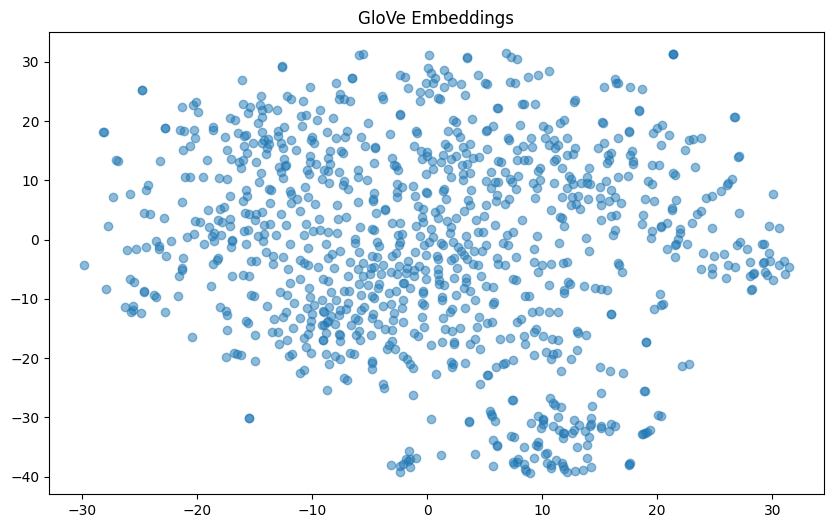

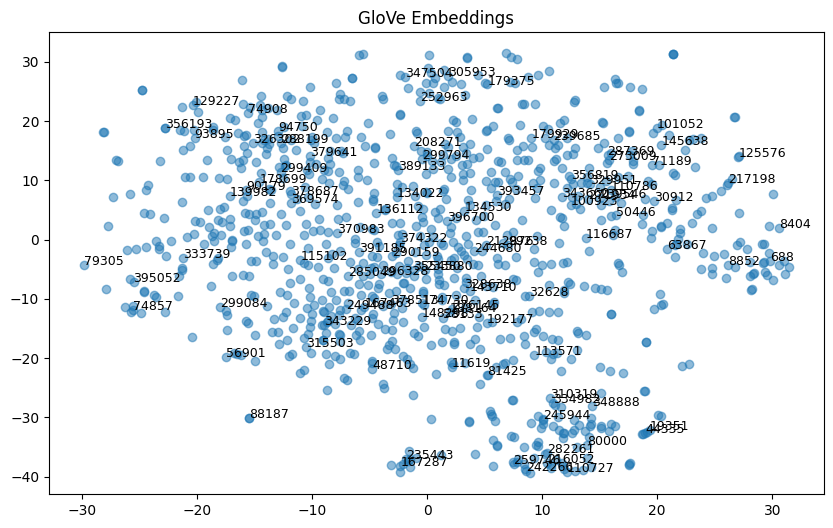

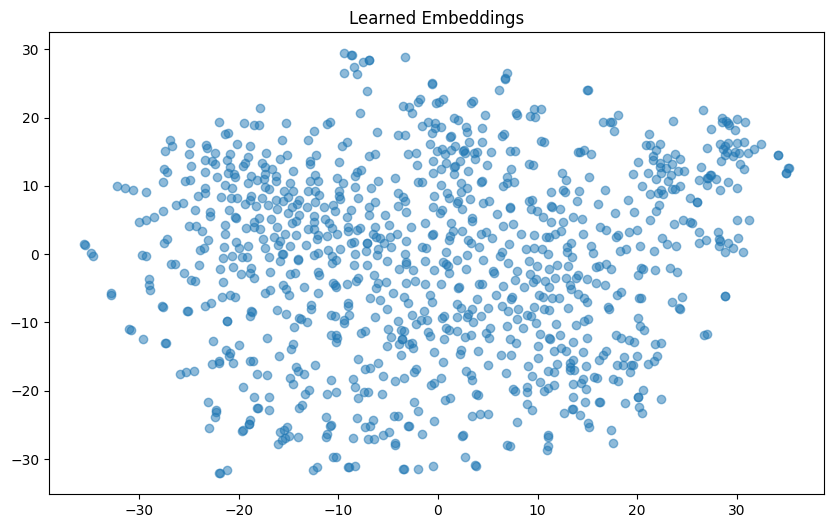

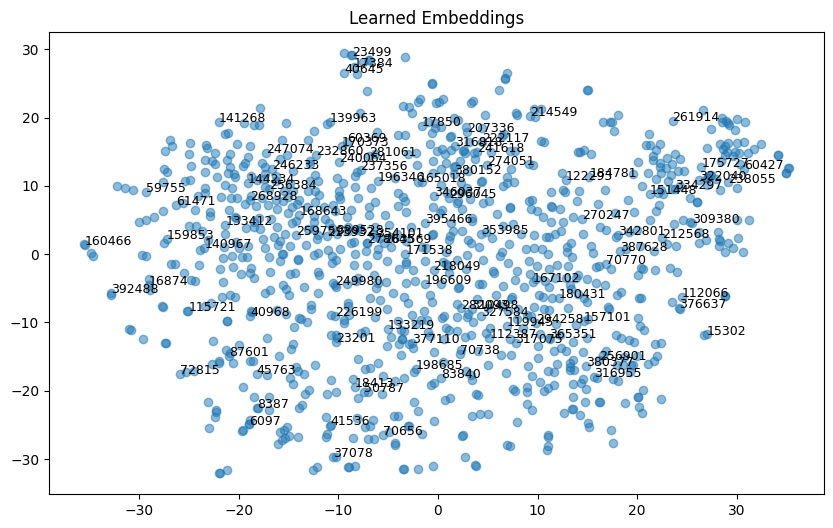

In [16]:

from sklearn.decomposition import PCA
def plot_embeddings(embeddings, title, max_points=1000):
    indices = torch.randperm(embeddings.shape[0])[:max_points]
    embeddings_subset = embeddings[indices]

    pca = PCA(n_components=50)
    reduced_data = pca.fit_transform(embeddings_subset.numpy())

    tsne = TSNE(n_components=2, random_state=42, perplexity=20)
    reduced_embeddings = tsne.fit_transform(reduced_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
    plt.title(title)
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)

    for i in range(min(100, len(reduced_embeddings))):  # Limit the number of labels to 100 for clarity
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(indices[i].item()), fontsize=9)

    plt.title(title)
    plt.show()

plot_embeddings(glove_embeddings, "GloVe Embeddings")
plot_embeddings(model.embedding.weight.detach(), "Learned Embeddings")
